In [1]:
import pandas as pd
from Bio import SeqIO, AlignIO, Seq
import numpy as np
from collections import Counter
from helper import *
import python_cipres.client as CipresClient

In [12]:
!mkdir -p ../output/test_clustering
for i in ['0.7','0.75','0.8','0.85','0.9']:
    !echo $i
    outfile = '../output/test_clustering/auto_uclust_all_'+str(i)+'.uc'
    !../bin/usearch11.0.667_i86linux32 -cluster_fast ../output/02_90p_autotrophic_rubisco_tree/autotrophic_rubisco_seq.faa -id $i -uc $outfile

0.7
usearch v11.0.667_i86linux32, 4.0Gb RAM (16.3Gb total), 8 cores
(C) Copyright 2013-18 Robert C. Edgar, all rights reserved.
https://drive5.com/usearch

License: yinonmoise.baron@weizmann.ac.il

00:00 71Mb    100.0% Reading ../output/02_90p_autotrophic_rubisco_tree/autotrophic_rubisco_seq.faa
00:00 110Mb   100.0% DF
00:00 111Mb  46287 seqs, 45447 uniques, 44939 singletons (98.9%)
00:00 111Mb  Min size 1, median 1, max 48, avg 1.02
00:00 118Mb   100.0% DB
00:03 170Mb   100.0% 107 clusters, max size 14732, avg 432.6
                                                            
      Seqs  45447 (45.4k)
  Clusters  107
  Max size  14732 (14.7k)
  Avg size  432.6
  Min size  1
Singletons  27, 0.1% of seqs, 25.2% of clusters
   Max mem  170Mb
      Time  3.00s
Throughput  15.1k seqs/sec.

0.75
usearch v11.0.667_i86linux32, 4.0Gb RAM (16.3Gb total), 8 cores
(C) Copyright 2013-18 Robert C. Edgar, all rights reserved.
https://drive5.com/usearch

License: yinonmoise.baron@weizmann.ac.il

00:0

In [114]:
type1_sub = pd.read_csv('../output/02_90p_autotrophic_rubisco_tree/type1_rubisco_subtypes.csv')
auto_90p = pd.read_csv('../output/02_90p_autotrophic_rubisco_tree/uclust_all_0.9_with_type.csv')
auto_90p['cut Target90'] = auto_90p['Target_y'].apply(lambda x: x.split(' ')[0])

In [115]:
auto_90p_with_type = auto_90p.merge(type1_sub,left_on='cut Target90',right_on='Label',how='outer')
auto_90p_with_type.loc[auto_90p_with_type.type =='I','type'] = auto_90p_with_type.loc[auto_90p_with_type.type =='I','Type']
auto_90p_with_type.to_csv('../output/02_90p_autotrophic_rubisco_tree/uclust_all_0.9_with_type_with_type1_subtypes.csv')

In [74]:
auto_rubisco = pd.read_csv('../output/02_90p_autotrophic_rubisco_tree/uclust_all_0.7_with_type.csv')

results = pd.DataFrame()
for i in ['0.7','0.75','0.8','0.85','0.9']:
    header = ['Type','Cluster','Size','%Id','Strand','Qlo','Tlo','Alignment','Query','Target']
    infile = '../output/test_clustering/auto_uclust_all_'+str(i)+'.uc'
    uclust = pd.read_csv(infile, sep='\t', names=header, index_col=False)
    uclust = uclust[uclust['Type'] !='S']
    uclust.loc[uclust['Target'] == '*','Target'] = uclust.loc[uclust['Target'] == '*','Query']
    uclust = auto_rubisco.merge(uclust,left_on='Query',right_on='Query')
    results[i] = uclust.groupby('type')['Target_y'].nunique()
results.sum()

0.7     107
0.75    159
0.8     251
0.85    409
0.9     776
dtype: int64

In [95]:
results = pd.DataFrame()
for i in ['0.7','0.75','0.8','0.85','0.9']:
    header = ['Type','Cluster','Size','%Id','Strand','Qlo','Tlo','Alignment','Query','Target']
    infile = '../output/test_clustering/auto_uclust_all_'+str(i)+'.uc'
    uclust = pd.read_csv(infile, sep='\t', names=header, index_col=False)
    uclust = uclust[uclust['Type'] !='S']
    uclust.loc[uclust['Target'] == '*','Target'] = uclust.loc[uclust['Target'] == '*','Query']
    uclust = uclust.merge(auto_90p_with_type[['Query','type']],left_on='Query',right_on='Query')
    results[i] = uclust.groupby('type')['Target'].nunique()
results

,0.7,0.75,0.8,0.85,0.9
type,,,,,
1,7,6,9,10,10
1a,5,7,13,34,87
1a/b,2,2,3,5,14
1b,6,19,28,49,136
1c,5,8,16,41,104
1cde,3,2,2,2,4
1d,5,8,12,23,79
1e,2,3,10,18,35
II,14,16,32,68,120


In [112]:
results.loc[['1b','1d']].sum()/results.sum()
results2 = results[results.index.str.startswith('I')]
results2.loc['I-prok'] = results.loc[['1a','1c','1e']].sum()
results2.loc['I-euk'] = results.loc[['1b','1d']].sum()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


In [113]:
results2

,0.7,0.75,0.8,0.85,0.9
type,,,,,
II,14,16,32,68,120
II/III,9,14,28,42,48
III-like,15,24,42,54,67
IIIa,22,28,32,34,39
IIIc,21,27,28,31,32
IV-outgroup,1,1,1,1,1
I-prok,12,18,39,93,226
I-euk,11,27,40,72,215


In [109]:
results2.sum()

0.7      94
0.75    128
0.8     202
0.85    323
0.9     533
dtype: int64

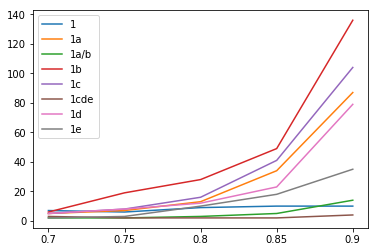

In [73]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.plot(results.T)
plt.legend(results.index)

In [96]:
results/results.sum()

,0.7,0.75,0.8,0.85,0.9
type,,,,,
1,0.059829,0.036364,0.035156,0.024272,0.012887
1a,0.042735,0.042424,0.050781,0.082524,0.112113
1a/b,0.017094,0.012121,0.011719,0.012136,0.018041
1b,0.051282,0.115152,0.109375,0.118932,0.175258
1c,0.042735,0.048485,0.062500,0.099515,0.134021
1cde,0.025641,0.012121,0.007812,0.004854,0.005155
1d,0.042735,0.048485,0.046875,0.055825,0.101804
1e,0.017094,0.018182,0.039062,0.043689,0.045103
II,0.119658,0.096970,0.125000,0.165049,0.154639


In [72]:
results.sum()

0.7      35
0.75     55
0.8      93
0.85    182
0.9     469
dtype: int64